# Importing Libraries

In [2]:
import numpy as np, pandas as pd
import json
import ast 
from textblob import TextBlob
import nltk
import torch
import pickle
from scipy import spatial
import warnings
warnings.filterwarnings('ignore')
import spacy
from nltk import Tree
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
#en_nlp = spacy.load('en')
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,QuantileTransformer

# Convert JSON to Pandas Dataframe

In [115]:
train = pd.read_json("/Users/devshreepatel/Desktop/LR/data/train-v1.1.json") #Read the train data JSON File
valid = pd.read_json("/Users/devshreepatel/Desktop/LR/data/dev-v1.1.json") #Read the valid data JSON File

In [116]:
train.shape, valid.shape

((442, 2), (48, 2))

In [117]:
contexts = []       
questions = []
answers_text = []
answers_start = []
for i in range(train.shape[0]):
    topic = train.iloc[i,0]['paragraphs'] # To select each paragraph from data and gather corresponding info of it.
    for sub_para in topic:
        for q_a in sub_para['qas']:
            questions.append(q_a['question']) # To get Question of each paragraph 
            answers_start.append(q_a['answers'][0]['answer_start']) # To get the start index of answer
            answers_text.append(q_a['answers'][0]['text']) # To get the Answer for the question
            contexts.append(sub_para['context']) # To get the context of the paragraph
df = pd.DataFrame({"context":contexts, "question": questions, "answer_start": answers_start, "text": answers_text})

In [118]:
df.shape

(87599, 4)

In [119]:
df.to_csv("data/train.csv", index = None) # Change JSON file to CSV file

## Create dictionary of sentence embeddings for faster computation

In [120]:
paras = list(df["context"].drop_duplicates().reset_index(drop= True)) # Create List of all Contexts and drop duplicates

In [173]:
len(paras)

18891

In [10]:
blob = TextBlob(" ".join(paras)) 
sentences = [item.raw for item in blob.sentences]

In [11]:
len(sentences)

92659

In [ ]:
from models import InferSent
V = 2
MODEL_PATH = '/Users/devshreepatel/Desktop/LR/encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V} # Model Parameters For Infersent Model
infersent = InferSent(params_model) # Infersent Pre Trained encoder by Facebook
infersent.load_state_dict(torch.load(MODEL_PATH)) # Load Dictionary

In [13]:
W2V_PATH = '/Users/devshreepatel/Desktop/LR/data/fastText/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH) # Set the Word To Vector Path for embeddings

In [14]:
infersent

InferSent(
  (enc_lstm): LSTM(300, 2048, bidirectional=True)
)

In [15]:
infersent.build_vocab(sentences, tokenize=True) # Using Function of InferSent Class to build vocabulary

Found 89231(/109703) words with w2v vectors
Vocab size : 89231


## Generating word embeddings

In [ ]:
dict_embeddings = {}
for i in range(len(sentences)):
    print(i)
    dict_embeddings[sentences[i]] = infersent.encode([sentences[i]], tokenize=True) # Encode the sentences in dict_embeddings

In [18]:
questions = list(df["question"]) #Use the question column from df and create a list

In [19]:
len(questions)

87599

In [ ]:
for i in range(len(questions)):
    print(i)
    dict_embeddings[questions[i]] = infersent.encode([questions[i]], tokenize=True) # Generate encoding for questions

# Create dictionary with each Sentence and corresponding word embeddings array 

In [21]:
d1 = {key:dict_embeddings[key] for i, key in enumerate(dict_embeddings) if i % 2 == 0} 
d2 = {key:dict_embeddings[key] for i, key in enumerate(dict_embeddings) if i % 2 == 1}

In [23]:
train = pd.read_csv("data/train.csv") # Load the train data CSV file

In [24]:
train.shape

(87599, 4)

### Loading Embedding dictionary

In [25]:
# Open the pickle file 1 with word embeddings and load to d1
with open("data/dict_1.pickle", "rb") as f:
    d1 = pickle.load(f)

In [26]:
# Open the pickle file 2 with word embeddings and load to d2
with open("data/dict_2.pickle", "rb") as f:
    d2 = pickle.load(f)

In [27]:
# Concatenate the two dictionaries with word embeddings in one dict_emb
dict_emb = dict(d1)
dict_emb.update(d2)

In [28]:
len(dict_emb)

179862

## Data Pre-Processing

In [29]:
# This function sets the value of column Target which is the sentence number in the paragraph which contains the answer.
def get_target(x):
    idx = -1
    for i in range(len(x["sentences"])):
        if x["text"] in x["sentences"][i]: idx = i
    return idx

In [30]:
train.head(3)

,context,question,answer_start,text
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building


In [31]:
train.shape

(87599, 4)

In [32]:
# Use of dropna function to drop null values using inplace=True to make the changes in CSV file automatic 
train.dropna(inplace=True)

## Processing Data

In [33]:
# This function to add the extra columns to the training data: sentences, target, sent_emb, quest_emb
def process_data(train):
    
    print("step 1")
    train['sentences'] = train['context'].apply(lambda x: [item.raw for item in TextBlob(x).sentences])
    
    print("step 2")
    train["target"] = train.apply(get_target, axis = 1)
    
    print("step 3")
    train['sent_emb'] = train['sentences'].apply(lambda x: [dict_emb[item][0] if item in
                                                           dict_emb else np.zeros(4096) for item in x])
    print("step 4")
    train['quest_emb'] = train['question'].apply(lambda x: dict_emb[x] if x in dict_emb else np.zeros(4096) )
        
    return train   

In [34]:
# Run this to process data to add columns 
train = process_data(train)

step 1
step 2
step 3
step 4


In [35]:
train.shape

(87598, 8)

In [36]:
train.head(3)

,context,question,answer_start,text,sentences,target,sent_emb,quest_emb
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous,"[Architecturally, the school has a Catholic ch...",5,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, 0.024210272, 0.069616325, -0.0..."
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ,"[Architecturally, the school has a Catholic ch...",2,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, -0.033483382, 0.040545918, -0...."
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building,"[Architecturally, the school has a Catholic ch...",3,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, -0.043944724, 0.14385942, -0.0..."


## Predicted Cosine & Euclidean Index

In [37]:
#Find the Cosine similarity Between Question and Answer 
def cosine_sim(x):
    li = []
    for item in x["sent_emb"]:
        li.append(spatial.distance.cosine(item,x["quest_emb"][0]))
    return li   

In [38]:
#This function is to find the argmin between all the distances of a single sentence array to find the predicted target ...
#sentence number
def pred_idx(distances):
    return np.argmin(distances)

In [39]:
# The euclidean distance and cosine similarity are calculated and predictions are made using above function and stored 
def predictions(train):
    
    train["cosine_sim"] = train.apply(cosine_sim, axis = 1)
    train["diff"] = (train["quest_emb"] - train["sent_emb"])**2
    train["euclidean_dis"] = train["diff"].apply(lambda x: list(np.sum(x, axis = 1)))
    del train["diff"]
    
    print("cosine start")
    
    train["pred_idx_cos"] = train["cosine_sim"].apply(lambda x: pred_idx(x))
    train["pred_idx_euc"] = train["euclidean_dis"].apply(lambda x: pred_idx(x))
    
    return train

In [ ]:
#Call to make the predictions
predicted = predictions(train)

In [42]:
predicted.shape

(87598, 12)

In [43]:
predicted.head(3)

,context,question,answer_start,text,sentences,target,sent_emb,quest_emb,cosine_sim,euclidean_dis,pred_idx_cos,pred_idx_euc
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous,"['Architecturally, the school has a Catholic c...",5,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 0.02421027 0.06961633 ... 0.0...,"[0.6835565567016602, 0.5527453124523163, 0.574...","[7.301305, 6.4764132, 7.214262, 6.9176197, 6.5...",5,5
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ,"['Architecturally, the school has a Catholic c...",2,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.03348338 0.04054592 ... -0.0...,"[0.6624992787837982, 0.5191770792007446, 0.592...","[5.717004, 5.076439, 6.3408985, 3.5867877, 4.8...",3,3
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building,"['Architecturally, the school has a Catholic c...",3,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.04394472 0.14385942 ... 0.0...,"[0.6164608299732208, 0.4940056800842285, 0.521...","[5.3495297, 4.8541417, 5.6286764, 2.8828857, 3...",3,3


In [44]:
predicted["cosine_sim"][0]

'[0.6835565567016602, 0.5527453124523163, 0.5747938454151154, 0.624308854341507, 0.619026243686676, 0.25835102796554565, 0.5743658542633057]'

In [45]:
predicted["euclidean_dis"][0]

'[7.301305, 6.4764132, 7.214262, 6.9176197, 6.519748, 3.6410067, 6.9080434]'

## Accuracy

In [46]:
# Calculate the accuracy between predicted and target values
def accuracy(target, predicted):
    acc = (target==predicted).sum()/len(target)
    return acc

### Accuracy for  euclidean Distance

In [47]:
print(accuracy(predicted["target"], predicted["pred_idx_euc"]))

0.488778282609192


### Accuracy for Cosine Similarity

In [48]:
print(accuracy(predicted["target"], predicted["pred_idx_cos"]))

0.5972282472202561


In [51]:
#Write back the final data with predicted values to a CSV file
predicted.to_csv("train_detect_sent.csv", index=None)

In [41]:
#Read the new CSV file
predicted = pd.read_csv("train_detect_sent.csv").reset_index(drop=True)

In [49]:
#Use spaCy Open source Library to load the data needed for to process for English Language
en_nlp=spacy.load('en')
doc = en_nlp(predicted.iloc[0,1])

In [50]:
predicted

,context,question,answer_start,text,sentences,target,sent_emb,quest_emb,cosine_sim,euclidean_dis,pred_idx_cos,pred_idx_euc
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous,"['Architecturally, the school has a Catholic c...",5,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 0.02421027 0.06961633 ... 0.0...,"[0.6835565567016602, 0.5527453124523163, 0.574...","[7.301305, 6.4764132, 7.214262, 6.9176197, 6.5...",5,5
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ,"['Architecturally, the school has a Catholic c...",2,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.03348338 0.04054592 ... -0.0...,"[0.6624992787837982, 0.5191770792007446, 0.592...","[5.717004, 5.076439, 6.3408985, 3.5867877, 4.8...",3,3
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building,"['Architecturally, the school has a Catholic c...",3,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.04394472 0.14385942 ... 0.0...,"[0.6164608299732208, 0.4940056800842285, 0.521...","[5.3495297, 4.8541417, 5.6286764, 2.8828857, 3...",3,3
3,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,381,a Marian place of prayer and reflection,"['Architecturally, the school has a Catholic c...",4,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.02113509 0.08985032 ... 0.0...,"[0.6685060262680054, 0.6087148487567902, 0.695...","[6.2550764, 6.3554144, 7.8789406, 4.5443306, 4...",3,3
4,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,92,a golden statue of the Virgin Mary,"['Architecturally, the school has a Catholic c...",1,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.02515129 0.08926863 ... 0.0...,"[0.7792749553918839, 0.528475284576416, 0.5735...","[7.5543714, 5.692802, 6.6871767, 4.9444075, 5....",3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
87593,"Kathmandu Metropolitan City (KMC), in order to...",In what US state did Kathmandu first establish...,229,Oregon,"['Kathmandu Metropolitan City (KMC), in order ...",1,"[array([ 0.00746889, -0.05648201, 0.10629363,...",[[ 0.00746889 -0.03403048 0.06046114 ... 0.0...,"[0.41991251707077026, 0.3826998472213745, 0.48...","[4.760933, 4.116004, 6.391081, 5.7619123]",1,1
87594,"Kathmandu Metropolitan City (KMC), in order to...",What was Yangon previously known as?,414,Rangoon,"['Kathmandu Metropolitan City (KMC), in order ...",2,"[array([ 0.00746889, -0.05648201, 0.10629363,...",[[ 0.00746889 -0.05823731 -0.00707996 ... -0.0...,"[0.7255948781967163, 0.698612630367279, 0.7624...","[7.763542, 7.0988116, 9.420061, 9.603617]",1,1
87595,"Kathmandu Metropolitan City (KMC), in order to...",With what Belorussian city does Kathmandu have...,476,Minsk,"['Kathmandu Metropolitan City (KMC), in order ...",2,"[array([ 0.00746889, -0.05648201, 0.10629363,...",[[ 0.00746889 -0.05044248 0.06999452 ... 0.0...,"[0.4843701124191284, 0.5179441869258881, 0.530...","[5.394357, 5.4583673, 6.8717723, 6.434966]",0,0
87596,"Kathmandu Metropolitan City (KMC), in order to...",In what year did Kathmandu create its initial ...,199,1975,"['Kathmandu Metropolitan City (KMC), in order ...",1,"[array([ 0.00746889, -0.05648201, 0.10629363,...",[[ 0.00746889 -0.03403048 0.05538646 ... 0.0...,"[0.49502629041671753, 0.4206138253211975, 0.52...","[5.523418, 4.4599686, 6.844032, 6.0133524]",1,1


In [51]:
predicted.shape

(87598, 12)

In [52]:
#ast.literal_eval to print sentence-wise
ast.literal_eval(predicted["sentences"][0])

['Architecturally, the school has a Catholic character.',
 "Atop the Main Building's gold dome is a golden statue of the Virgin Mary.",
 'Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".',
 'Next to the Main Building is the Basilica of the Sacred Heart.',
 'Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection.',
 'It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.',
 'At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.']

In [53]:
#Here all the paragraphs with number of sentences 10 or less are taken from data
predicted = predicted[predicted["sentences"].apply(lambda x: len(ast.literal_eval(x)))<11].reset_index(drop=True)

In [54]:
#Every array value of cosine similarity and euclidean distance for each sentence are separated in columns as we have to work
#on the numerical distance data and every Question Answer pair has array for euclidean distance and cosine similarity
def create_features(predicted):
    train = pd.DataFrame()
     
    for k in range(len(predicted["euclidean_dis"])):
        dis = ast.literal_eval(predicted["euclidean_dis"][k])
        for i in range(len(dis)):
            train.loc[k, "column_euc_"+"%s"%i] = dis[i]
    
    print("Finished")
    
    for k in range(len(predicted["cosine_sim"])):
        dis = ast.literal_eval(predicted["cosine_sim"][k].replace("nan","1"))
        for i in range(len(dis)):
            train.loc[k, "column_cos_"+"%s"%i] = dis[i]
            
    train["target"] = predicted["target"]
    return train

In [55]:
# Call to create features and convert distances to columns
train = create_features(predicted)

Finished


In [56]:
train.to_csv("train_final.csv", index=None)

In [158]:
train2.to_csv("train_2.csv",index=None)

## start here

In [3]:
#Read the new CSV file
train1 = pd.read_csv("train_final.csv").reset_index(drop=True)

In [4]:
train1

,column_euc_0,column_euc_1,column_euc_2,column_euc_3,column_euc_4,column_euc_5,column_euc_6,column_euc_7,column_euc_8,column_euc_9,...,column_cos_1,column_cos_2,column_cos_3,column_cos_4,column_cos_5,column_cos_6,column_cos_7,column_cos_8,column_cos_9,target
0,7.301305,6.476413,7.214262,6.917620,6.519748,3.641007,6.908043,NaN,NaN,NaN,...,0.552745,0.574794,0.624309,0.619026,0.258351,0.574366,NaN,NaN,NaN,5
1,5.717004,5.076439,6.340898,3.586788,4.826955,7.294750,6.392016,NaN,NaN,NaN,...,0.519177,0.592157,0.395893,0.572930,0.594844,0.632305,NaN,NaN,NaN,2
2,5.349530,4.854142,5.628676,2.882886,3.573071,6.292664,5.433945,NaN,NaN,NaN,...,0.494006,0.521783,0.316489,0.421474,0.506190,0.533841,NaN,NaN,NaN,3
3,6.255076,6.355414,7.878941,4.544331,4.577210,7.192090,7.930581,NaN,NaN,NaN,...,0.608715,0.695520,0.465277,0.498301,0.558794,0.736132,NaN,NaN,NaN,4
4,7.554371,5.692802,6.687177,4.944407,5.559352,7.806414,6.598026,NaN,NaN,NaN,...,0.528475,0.573556,0.488644,0.583152,0.594557,0.594187,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85114,4.760933,4.116004,6.391081,5.761912,NaN,NaN,NaN,NaN,NaN,NaN,...,0.382700,0.485660,0.461544,NaN,NaN,NaN,NaN,NaN,NaN,1
85115,7.763542,7.098812,9.420061,9.603617,NaN,NaN,NaN,NaN,NaN,NaN,...,0.698613,0.762461,0.821555,NaN,NaN,NaN,NaN,NaN,NaN,2
85116,5.394357,5.458367,6.871772,6.434966,NaN,NaN,NaN,NaN,NaN,NaN,...,0.517944,0.530936,0.525017,NaN,NaN,NaN,NaN,NaN,NaN,2
85117,5.523418,4.459969,6.844032,6.013352,NaN,NaN,NaN,NaN,NaN,NaN,...,0.420614,0.527569,0.487704,NaN,NaN,NaN,NaN,NaN,NaN,1


In [5]:
#Finding Maximum for all the columns
train1.apply(max, axis = 0)

column_euc_0    29.927914
column_euc_1    40.290561
column_euc_2    33.286404
column_euc_3    34.140771
column_euc_4    36.115491
column_euc_5    35.623532
column_euc_6    39.640774
column_euc_7          NaN
column_euc_8          NaN
column_euc_9          NaN
column_cos_0     1.491517
column_cos_1     1.489619
column_cos_2     1.455926
column_cos_3     1.490736
column_cos_4     1.415583
column_cos_5     1.355459
column_cos_6     1.418385
column_cos_7          NaN
column_cos_8          NaN
column_cos_9          NaN
target           9.000000
dtype: float64

In [6]:
#As for all the sentences the number of array values in cosine similarity and euclidean distance array are not same so we
#replace those values accordingly by 60 and 1
subset1 = train1.iloc[:,:10].fillna(60)
subset2 = train1.iloc[:,10:].fillna(1)

In [7]:
 subset1.head(3)

,column_euc_0,column_euc_1,column_euc_2,column_euc_3,column_euc_4,column_euc_5,column_euc_6,column_euc_7,column_euc_8,column_euc_9
0,7.301305,6.476413,7.214262,6.917620,6.519748,3.641007,6.908043,60.0,60.0,60.0
1,5.717004,5.076439,6.340898,3.586788,4.826955,7.294750,6.392016,60.0,60.0,60.0
2,5.349530,4.854142,5.628676,2.882886,3.573071,6.292664,5.433945,60.0,60.0,60.0


In [8]:
# After the update of NaN values in both euclidean and cosine subsets they are concatenated for final use
train2 = pd.concat([subset1, subset2],axis=1, join_axes=[subset1.index])

In [9]:
# Maximum for all columns
train2.apply(max, axis = 0)

column_euc_0    29.927914
column_euc_1    60.000000
column_euc_2    60.000000
column_euc_3    60.000000
column_euc_4    60.000000
column_euc_5    60.000000
column_euc_6    60.000000
column_euc_7    60.000000
column_euc_8    60.000000
column_euc_9    60.000000
column_cos_0     1.491517
column_cos_1     1.489619
column_cos_2     1.455926
column_cos_3     1.490736
column_cos_4     1.415583
column_cos_5     1.355459
column_cos_6     1.418385
column_cos_7     1.354246
column_cos_8     1.315012
column_cos_9     1.159472
target           9.000000
dtype: float64

In [10]:
# Normalization of final train data between 0 to 1
scaler = MinMaxScaler()
X = scaler.fit_transform(train2.iloc[:,:-1])

In [11]:
X.shape  #printing shape of X

(85119, 20)

In [12]:
X

array([[0.23388115, 0.10277595, 0.1112316 , ..., 0.71921987, 0.74207714,
        0.84381084],
       [0.18023799, 0.07930797, 0.09652653, ..., 0.71921987, 0.74207714,
        0.84381084],
       [0.1677956 , 0.07558157, 0.08453465, ..., 0.71921987, 0.74207714,
        0.84381084],
       ...,
       [0.16931342, 0.0857103 , 0.10546501, ..., 0.71921987, 0.74207714,
        0.84381084],
       [0.17368332, 0.06897399, 0.10499793, ..., 0.71921987, 0.74207714,
        0.84381084],
       [0.23098827, 0.11801073, 0.16833388, ..., 0.71921987, 0.74207714,
        0.84381084]])

In [13]:
train1.iloc[:,-1]  #Printing last column of all rows

0        5
1        2
2        3
3        4
4        1
        ..
85114    1
85115    2
85116    2
85117    1
85118    0
Name: target, Length: 85119, dtype: int64

## Obtaining Eigen Values and Vectors

In [13]:
#calculating eigen values and eigen vectors
eigvals, eigvecs = np.linalg.eig(np.matmul(X.T,X)) #fetching eigen values and eigen vectors

idx = eigvals.argsort()[::-1]   #Sorting the eigen values in descending order

eigvals = eigvals[idx]  #Getting eigen values in that order

eigvecs = eigvecs[:,idx]  #Fetching the eigen vectors corresponding to eigen values

In [14]:
np.matmul(X.T,X).shape  #Displaying shape of matrix multiplication of X Transpose and X

(20, 20)

In [15]:
eigvals #Displaying eigen values

array([6.82719996e+05, 2.69746040e+04, 1.25780234e+04, 6.35226721e+03,
       4.69533312e+03, 3.65588802e+03, 2.76153078e+03, 1.85492816e+03,
       1.24731151e+03, 1.03511958e+03, 7.08657571e+02, 4.46083726e+02,
       3.15441411e+02, 2.77861826e+02, 2.56116509e+02, 1.99118547e+02,
       1.82047965e+02, 1.04305528e+02, 6.93401787e+01, 3.42316421e+01])

In [16]:
eigvecs #Displaying eigen vectors

array([[ 6.93143340e-02,  4.40384176e-02, -5.71697628e-02,
        -4.60286463e-02,  7.86862204e-02,  3.20841027e-03,
        -1.31578012e-01,  1.50141754e-01,  3.53369469e-02,
         1.56050849e-01, -1.60877628e-01, -8.87047165e-04,
         2.98537964e-02,  1.61594223e-02,  6.01674787e-02,
        -9.28056556e-01, -1.55344508e-01,  3.91988386e-03,
         2.45299369e-03, -1.06887941e-02],
       [ 4.33177706e-02, -2.12674931e-02, -1.13206060e-01,
         7.27892948e-02,  1.55998821e-01, -1.76245008e-01,
        -3.21386712e-02,  1.70006201e-01, -7.76755829e-01,
        -2.27542320e-01, -1.13777166e-01, -1.85875251e-01,
        -2.42610748e-01, -3.64104969e-01,  6.47918536e-03,
        -1.11368453e-02, -1.64065350e-03, -2.54489850e-04,
        -1.34752509e-03,  1.21274016e-03],
       [ 6.92391377e-02, -1.84138391e-01, -3.49158152e-01,
         3.74848458e-01,  3.40053068e-01, -5.50567252e-01,
         2.71750119e-01, -2.09923960e-01,  1.82398663e-01,
         1.01959324e-02, -1.1

## Calculating PCA

In [20]:
#Function for normalisation
def normalize(X):
    mu = np.mean(X)  #Finding mean of X
    std = np.std(X, axis=0)  #Finding standard deviation of X
    std_filled = std.copy()  #Storing std in a new variable
    std_filled[std==0] = 1.  #Placing 1 where value is 0 in std
    Xbar =  (X-mu)/std_filled  #Calculating normalised X -> Xbar        
    return Xbar, mu, std   #Returns Xbar, mean and standard deviation


The covariance matrix can be calculated as :
<img src = "cov.png">
Matrix after reducing the dimensions can be formed as :
<img src = "compress.png">
Projection matrix can be calculated as : 
<img src = "proj.png">

In [ ]:
Xbar,mu,std=normalize(X)  #Normalising the matrix X by calling normalise function
covariance=np.matmul(Xbar.T,Xbar)  #Finding covariance matrix by multiplying normalised matrix and its transpose
S=covariance  #Storing in variable S
eigvals,eigvecs=np.linalg.eig(S)  #Calculating eigen values and vectors of covariance matrix
idx = eigvals.argsort()[::-1]   #Sorting the eigen values in descending order
eigvals = eigvals[idx]  #Getting eigen values in that order
eigvecs = eigvecs[:,idx]  #Fetching the eigen vectors corresponding to eigen values
B = np.stack(eigvecs[:,:15])  #Selecting eigen vectors only upto 15 features
P = np.matmul(B,B.T)  #Matrix multiplication of B and B transpose
X_reconstruct=np.matmul(P,X.T)  #Calculating reconstruction matrix by (X_Transpose * P)
X_reconstruct=X_reconstruct.T  #Taking transpose of reconstructed matrix

In [19]:
B.shape  #Displaying shape

In [22]:
X_reconstruct  #Displaying reconstructed X

array([[0.24158254, 0.10599513, 0.1244064 , ..., 0.81955732, 0.79702055,
        0.88208912],
       [0.19165141, 0.0840962 , 0.11565174, ..., 0.84154205, 0.8239859 ,
        0.90735149],
       [0.17831808, 0.08003549, 0.10139699, ..., 0.83145445, 0.81476258,
        0.90213154],
       ...,
       [0.16671408, 0.08491819, 0.09548483, ..., 0.69922149, 0.69996569,
        0.82594423],
       [0.171072  , 0.06815381, 0.09532167, ..., 0.70030721, 0.70146704,
        0.82603383],
       [0.22772874, 0.11697466, 0.15639542, ..., 0.69501229, 0.69287508,
        0.82119588]])

In [23]:
X_reconstruct.shape

(85119, 20)

## PCA vs Variance

In [24]:
std=np.std(B,axis=0)  #standard deviation
var=np.square(std)  #variance

In [25]:
var

array([0.04999991, 0.00506238, 0.04707097, 0.04843382, 0.04975318,
       0.04989952, 0.04999965, 0.04999718, 0.04998623, 0.04999498,
       0.04999799, 0.04985184, 0.04996196, 0.0499981 , 0.04999549])

In [26]:
no_of_comp=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] #,6,7,8,9,10,11,12,13,14,15,16,17

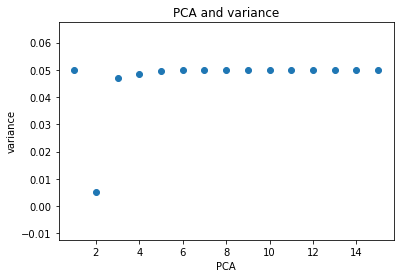

In [27]:
import matplotlib.pyplot as plt

plt.scatter(no_of_comp,var)  #Plotting variance along number of components
plt.title('PCA and variance')  #title
plt.ylabel('variance')  # Y axis label
plt.xlabel('PCA')  # X axis label
plt.show()  #Displaying figure

## Mean Square error 

In [28]:
np.square(X_reconstruct - X).sum(axis=1).mean()

0.06693887014469453

## Plotting eigen values vs indices

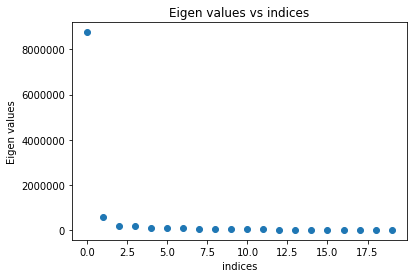

In [29]:
import matplotlib.pyplot as plt
#plt.plot(idx,eigvals)
plt.scatter(idx,eigvals)
plt.title('Eigen values vs indices')
plt.ylabel('Eigen values')
plt.xlabel('indices')
plt.show()

In [15]:
# Split the training data and testing data with 80:20 ratio
train_x, test_x, train_y, test_y = train_test_split(X,
train1.iloc[:,-1], train_size=0.8)

In [16]:
train2.head()

,column_euc_0,column_euc_1,column_euc_2,column_euc_3,column_euc_4,column_euc_5,column_euc_6,column_euc_7,column_euc_8,column_euc_9,...,column_cos_1,column_cos_2,column_cos_3,column_cos_4,column_cos_5,column_cos_6,column_cos_7,column_cos_8,column_cos_9,target
0,7.301305,6.476413,7.214262,6.917620,6.519748,3.641007,6.908043,60.0,60.0,60.0,...,0.552745,0.574794,0.624309,0.619026,0.258351,0.574366,1.0,1.0,1.0,5
1,5.717004,5.076439,6.340898,3.586788,4.826955,7.294750,6.392016,60.0,60.0,60.0,...,0.519177,0.592157,0.395893,0.572930,0.594844,0.632305,1.0,1.0,1.0,2
2,5.349530,4.854142,5.628676,2.882886,3.573071,6.292664,5.433945,60.0,60.0,60.0,...,0.494006,0.521783,0.316489,0.421474,0.506190,0.533841,1.0,1.0,1.0,3
3,6.255076,6.355414,7.878941,4.544331,4.577210,7.192090,7.930581,60.0,60.0,60.0,...,0.608715,0.695520,0.465277,0.498301,0.558794,0.736132,1.0,1.0,1.0,4
4,7.554371,5.692802,6.687177,4.944407,5.559352,7.806414,6.598026,60.0,60.0,60.0,...,0.528475,0.573556,0.488644,0.583152,0.594557,0.594187,1.0,1.0,1.0,1


In [86]:
train2.iloc[:,10]

0        0.683557
1        0.662499
2        0.616461
3        0.668506
4        0.779275
           ...   
85114    0.419913
85115    0.725595
85116    0.484370
85117    0.495026
85118    0.660581
Name: column_cos_0, Length: 85119, dtype: float64

## Applying Logistic Regression

Hypothesis for logistic regression :
<img src="hypothesis.png">
It can be written as :
<img src = "hypo.png">
Cost function is defined as :
<img src = "lr2.png">

In [17]:
#Applying Logistic Regression using sklearn library
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='saga',max_iter=200)
mul_lr.fit(train_x, train_y)

print("Multinomial Logistic regression Train Accuracy : ", metrics.accuracy_score(train_y, mul_lr.predict(train_x)))
print("Multinomial Logistic regression Test Accuracy : ", metrics.accuracy_score(test_y, mul_lr.predict(test_x)))


Multinomial Logistic regression Train Accuracy :  0.627021073500257
Multinomial Logistic regression Test Accuracy :  0.621828007518797


## Applying Logistic Regression Using Regularization

Cost function for logistic regression with regularization:
<img src = "regularisation.png">

In [33]:
#Applying Logistic Regression using sklearn library L2 Regularization
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='saga',max_iter=200,penalty='l2')
mul_lr.fit(train_x, train_y)

print("Multinomial Logistic regression Train Accuracy : ", metrics.accuracy_score(train_y, mul_lr.predict(train_x)))
print("Multinomial Logistic regression Test Accuracy : ", metrics.accuracy_score(test_y, mul_lr.predict(test_x)))


Multinomial Logistic regression Train Accuracy :  0.6199133563404068
Multinomial Logistic regression Test Accuracy :  0.6188322368421053


In [ ]:
#Plot two graphs 'Accuracy v/s Epoch' and 'Loss v/s Epoch'
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'], loc='upper left')
plt.show()

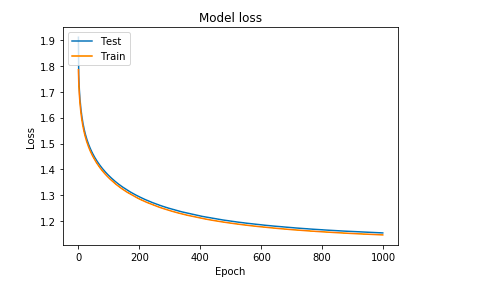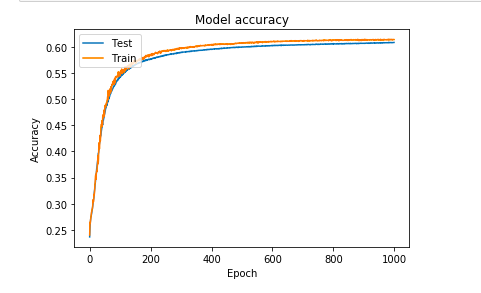

In [34]:
y=mul_lr.predict(train_x) #Predicting values of y

In [35]:
train_y=train_y.fillna(0)

In [36]:
train_y=train_y.to_numpy() #Converting to numpy array

In [37]:
#Counting number of unmatched samples
count=0
for i in range(68095):
    if y[i]!=train_y[i]:  #Condition for inequality
        count=count+1

In [38]:
#loss
(count)/68095

0.3800866436595932

In [39]:
#mean square error
(np.square(y - train_y).sum())/68095

2.2268742198399294

In [40]:
#fscore
from sklearn.metrics import f1_score
f1_score(train_y, y, average='micro')

0.6199133563404068

## Random Forest Classifier

In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

<center> Mathematics for Random Forest : <br> </center> <br>
The importance of each feature on a decision tree is given as :
<img src = "feature.png">
where, 
<img src = "fini.png">
Normalising of features :
<img src = "normfi.png">
The final feature importance is computed as :
<img src = "rffi.png">
<center> T = total number of trees </center>

In [149]:
rf = RandomForestClassifier(min_samples_leaf=3, n_estimators=5)
rf.fit(train_x, train_y)

print("Random Forest Train Accuracy : ", metrics.accuracy_score(train_y, rf.predict(train_x)))
print("Random Forest Test Accuracy ", metrics.accuracy_score(test_y, rf.predict(test_x)))

Multinomial Logistic regression Train Accuracy :  0.761715250752625
Multinomial Logistic regression Test Accuracy :  0.6051456766917294


## XG BOOST Classifier

In [129]:
import xgboost as xgb
from xgboost import plot_tree

<center> Mathematics behind XGBoost : <br> </center>
Need for taylor approximation : <br> <br>
The original objective function of XGBoost should be converted to a function in the Euclidean domain, in order to be able to use traditional optimization techniques. <br> <br>
Taylor Approximation:
<img src = "taylor.png"> <br>
By the above formulation, the error will be reduced for each sequential generation of tree since the boosting will produce trees based on previous errors. 

In [138]:
xg = xgb.XGBClassifier(max_depth=3)
xg.fit(train_x, train_y)

print("XgBoost Train Accuracy : ", metrics.accuracy_score(train_y, xg.predict(train_x)))
print("XgBoost Test Accuracy : ", metrics.accuracy_score(test_y, xg.predict(test_x)))

Multinomial Logistic regression Train Accuracy :  0.6661428886114986
Multinomial Logistic regression Test Accuracy :  0.6524906015037594


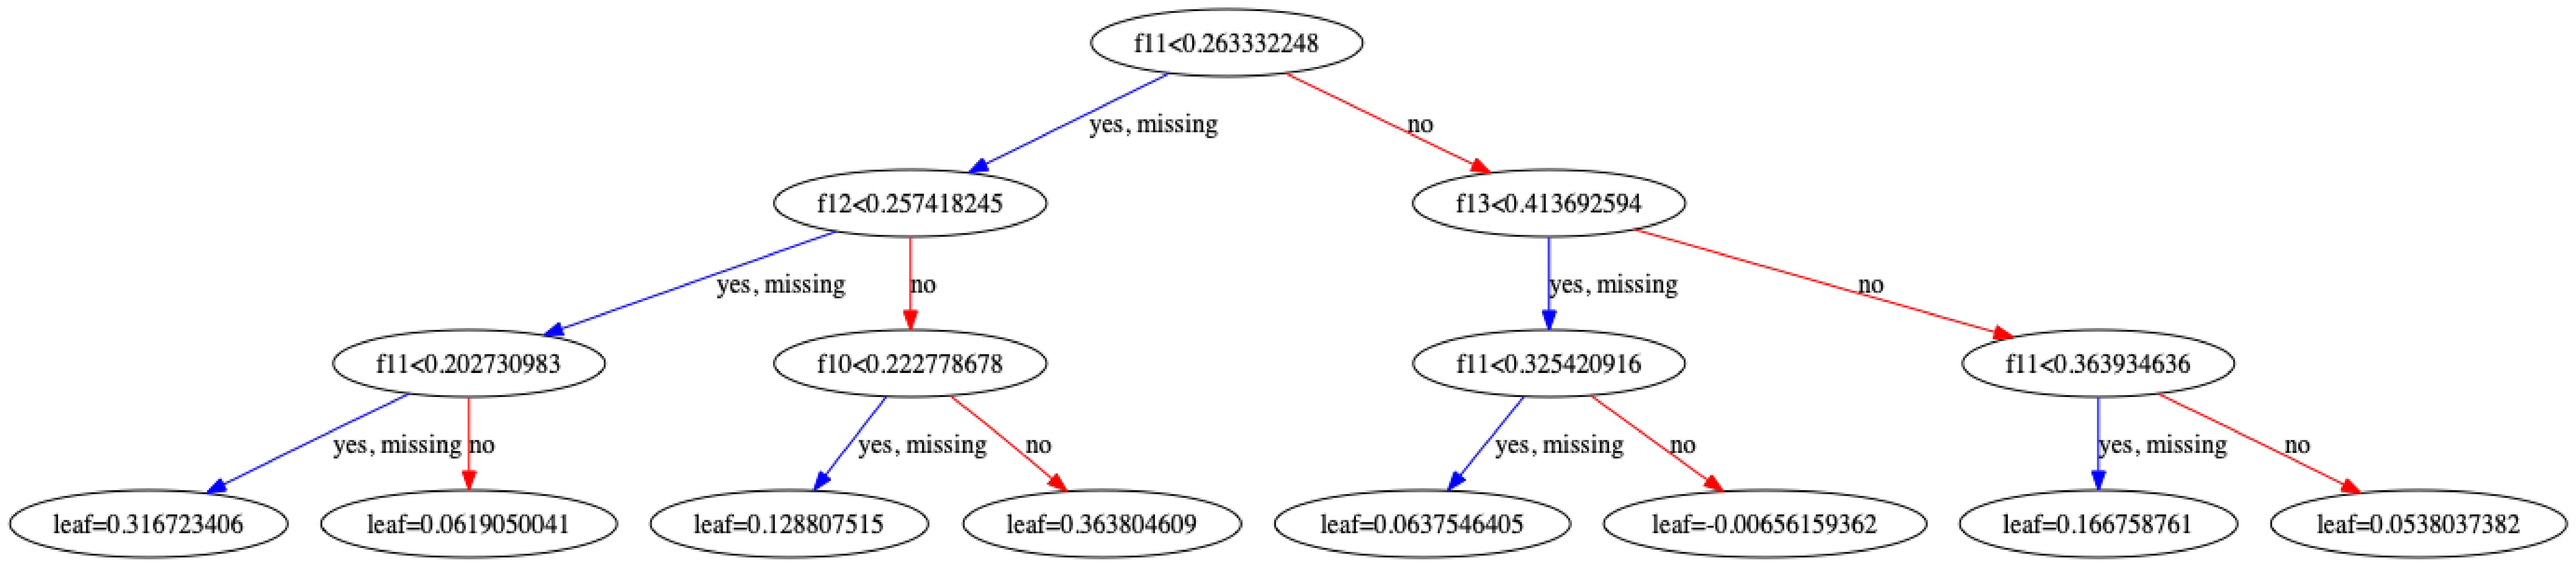

In [159]:
xgb.plot_tree(xg, num_trees=2)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

## Support Vector Machine

In [45]:
from sklearn import svm  #Importing module for svm

In [60]:
clf=svm.SVC(kernel='linear', random_state=1)  #Choosing linear kernel and random_state as 1 for svm

In [61]:
clf.fit(train_x,train_y)  #Training on svm

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

<center> Problem formulation </center> <br>
Equation of two-dimensional hyperplane is given as : <br>
<img src = "form.png">
<img src = "formhn1.png">
<img src = "formhn2.png">
Two hyperplanes passing through support vectors of class +1 and -1 can be given as : <br>
<img src = "formh1.png">
The equation of margin is given as : <br>
<img src = "formhm.png">
The parameters w and b will keep updating till an optimal hyperplane is obtained which will maximise the margin. 

In [49]:
print("SVM train Accuracy : ", metrics.accuracy_score(train_y, clf.predict(train_x)))
print("SVM test Accuracy : ", metrics.accuracy_score(test_y, clf.predict(test_x)))

SVM train Accuracy :  0.6212937807474851
SVM test Accuracy :  0.6214755639097744


In [62]:
clf.support_vectors_.shape #shape of support vectors

(52295, 20)

In [59]:
clf.support_ ##indices of support vectors

array([  440,   663,  1135, ..., 65574, 66581, 68051], dtype=int32)

In [55]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', C=10000, gamma=0.01, random_state=1) #when c=50 accuracy-around 49
clf.fit(train_x,train_y)
print("SVM train Accuracy : ", metrics.accuracy_score(train_y, clf.predict(train_x)))
print("SVM test Accuracy : ", metrics.accuracy_score(test_y, clf.predict(test_x)))

SVM train Accuracy :  0.6290476540127763
SVM test Accuracy :  0.6272908834586466


In [56]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=10000, gamma=0.01, random_state=1)
clf.fit(train_x,train_y)
print("SVM train Accuracy : ", metrics.accuracy_score(train_y, clf.predict(train_x)))
print("SVM test Accuracy : ", metrics.accuracy_score(test_y, clf.predict(test_x)))

SVM train Accuracy :  0.6704750715911594
SVM test Accuracy :  0.6630639097744361


In [75]:
#Importing modules from sklearn for svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

#Defining a parameter grid with kernels, regularisation parameters and kernel coefficients
param_grid = [{'kernel': ['linear']}, {'kernel': ['poly', 'rbf'], 'C': [0.1, 1,100, 1000],
'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}]

#Printing to search for best model and corresponding parameters
print("Total length to check for best model and parameters: ",len(list(ParameterGrid(param_grid))))

#Performing grid search to look for the best tuning hyperparameters
gsc = GridSearchCV(SVC(),param_grid,scoring='accuracy',cv=5)
grid_result = gsc.fit(train_x, train_y)  #Trainging with the obtained parameters

#Printing Best values of the parameters
print("Best Parameters: ", grid_result.best_params_)
print("Best Estimator: ", grid_result.best_estimator_)
print("Best Score: ", grid_result.best_score_)

Total length to check for best model and parameters:  57
Best Parameters:  {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
Best Estimator:  SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best Score:  0.43


In [74]:
print("SVM train Accuracy : ", metrics.accuracy_score(train_y, grid_result.predict(train_x)))
print("SVM test Accuracy : ", metrics.accuracy_score(test_y, grid_result.predict(test_x)))

SVM train Accuracy :  0.515265437991042
SVM test Accuracy :  0.5118068609022557


## Gaussian Mixture Model

In [104]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from pandas import DataFrame 
from sklearn import datasets 
from sklearn.mixture import GaussianMixture 

In [105]:

d1 = pd.DataFrame(X[:,0]) #euclidean distance column 1
d2 = pd.DataFrame(X[:,10]) #cosine similarity column 1

d = pd.concat([d1, d2],axis=1, join_axes=[d1.index])
# plot the data 
#temp

In [106]:
gmm = GaussianMixture(n_components = 10) 
gmm.fit(d) 

# Assign a label to each sample 
labels = gmm.predict(d) 
d['labels']= labels 
d0 = d[d['labels']== 0] 
d1 = d[d['labels']== 1] 
d2 = d[d['labels']== 2]
d3 = d[d['labels']== 3]
d4 = d[d['labels']== 4]
d5 = d[d['labels']== 5]
d6 = d[d['labels']== 6]
d7 = d[d['labels']== 7]
d8 = d[d['labels']== 8]
d9 = d[d['labels']== 9]


  


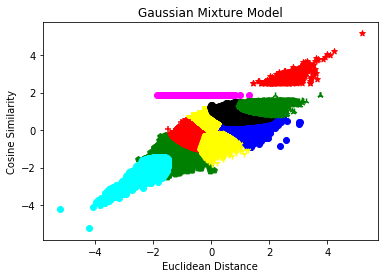

In [110]:
# plot three clusters in same plot 
plt.scatter(d0.iloc[:,0], d0.iloc[:,1], c ='red' ,marker='*') 
plt.scatter(d1.iloc[:,0], d1.iloc[:,1], c ='yellow',marker='s') 
plt.scatter(d2.iloc[:,0], d2.iloc[:,1], c ='green',marker='p') 
plt.scatter(d3.iloc[:,0], d3.iloc[:,1], c ='blue') 
plt.scatter(d4.iloc[:,0], d4.iloc[:,1], c ='black') 
plt.scatter(d5.iloc[:,0], d5.iloc[:,1], c ='magenta') 
plt.scatter(d6.iloc[:,0], d6.iloc[:,1], c ='cyan') 
plt.scatter(d7.iloc[:,0], d7.iloc[:,1], c ='red',marker='+')
plt.scatter(d8.iloc[:,0], d8.iloc[:,1], c ='yellow',marker='1') 
plt.scatter(d9.iloc[:,0], d9.iloc[:,1], c ='green',marker='2') 
plt.xlabel('Euclidean Distance') 
# frequency label 
plt.ylabel('Cosine Similarity') 
# plot title 
plt.title('Gaussian Mixture Model') 
# function to show the plot 
plt.show() 

In [35]:
qt = QuantileTransformer(n_quantiles = len(train2.iloc[:,0]), output_distribution = 'normal')

## transforming above distributions to Normal distribution ##
X = train2.iloc[:,:-1].to_numpy()
#Y = train2.iloc[:,1].to_numpy().reshape(-1,1)

X = qt.fit_transform(X)
#Y = qt.fit_transform(Y)
print('distributions transformed')

distributions transformed


## Sentiment Analysis

In [121]:
#Importing nltk library for Valence Aware Dictionary and Sentiment Reasoner (VADER)

import nltk
nltk.download('vader_lexicon')  #Vader is a tool for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()  #Initialising sid with SentimentIntensityAnalyzer
a = [0]*(len(paras)+1)  
b = [0]*(len(paras)+1)
for i in range(0,len(paras)-1):
    a[i] = sid.polarity_scores(paras[i])  #Polarity indices are obtained using polarity_scores method
    b[i] = a[i]["compound"]  #The Compound score is a metric that calculates the sum of all the ratings which have been normalized between -1 and +1

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1108)>


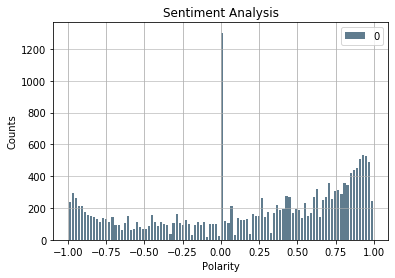

In [122]:
import pandas as pd
import numpy

b1=numpy.array(b)  #Converting the compound scores obtained to numpy array
b2=pd.DataFrame(b1)  #Converting to dataframe

#Plotting a histogram
b2.plot.hist(grid=True, bins=100,rwidth=0.7,
                   color='#607c8e')

#Setting title, x-axis label and y-axis label
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

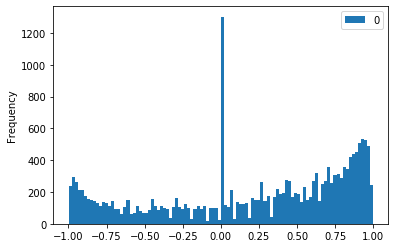

In [123]:
#Plotting a histogram

import pandas as pd
import numpy as np
import plotly
from plotly import __version__
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
df=pd.DataFrame(b)
df.plot(
    kind='hist',
    bins=100)


In [124]:
#Plotting a histogram

df=pd.DataFrame(b)
df.iplot(
    kind='hist',
    bins=100,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')